In [2]:
# Step 1: Imports
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


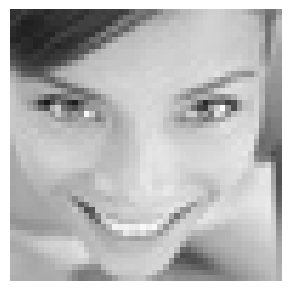

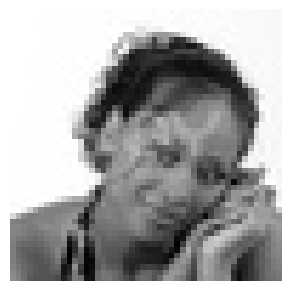

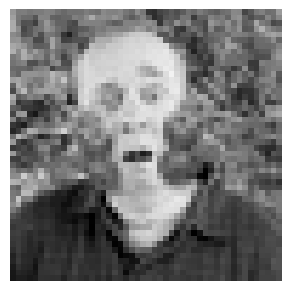

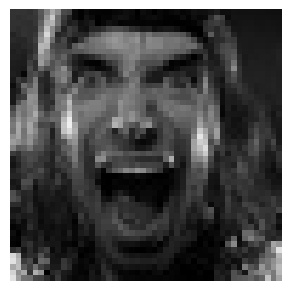

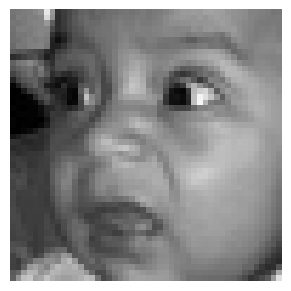

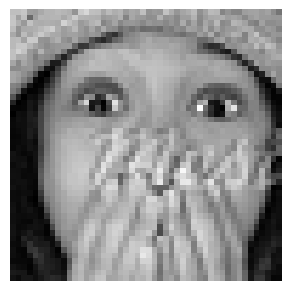

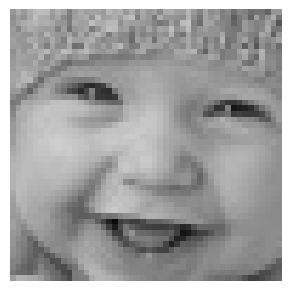

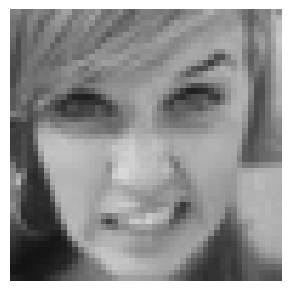

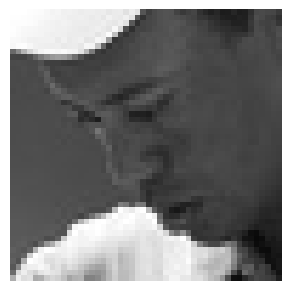

In [9]:
# Step 2: Visualize Random Images
images = glob("/kaggle/input/fer2013/train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image)); plt.axis('off')

In [11]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen_validation = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    "/kaggle/input/fer2013/train",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

validation_generator = datagen_validation.flow_from_directory(
    "/kaggle/input/fer2013/test",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
# Step 4: Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [13]:
# Step 5: Model Architecture
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    return x

def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

def model_fer(input_shape):
    inputs = Input(input_shape)
    x = Convolution(inputs, 64, (3, 3))
    x = Convolution(x, 128, (5, 5))
    x = Convolution(x, 512, (3, 3))
    x = Convolution(x, 512, (3, 3))
    x = Flatten()(x)
    x = Dense_f(x, 256)
    x = Dense_f(x, 512)
    outputs = Dense(7, activation="softmax")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    return model


In [14]:
# Step 6: Initialize Model
model = model_fer((48, 48, 1))
model.summary()


I0000 00:00:1751100113.014639      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [18]:
# Step 7: Training
checkpoint = ModelCheckpoint("best_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [checkpoint, reduce_lr, early_stop]

steps_per_epoch = math.ceil(train_generator.n / batch_size)
validation_steps = math.ceil(validation_generator.n / batch_size)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.1779 - loss: 2.0718
Epoch 1: val_accuracy improved from -inf to 0.17191, saving model to best_weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 143s 319ms/step - accuracy: 0.1779 - loss: 2.0716 - val_accuracy: 0.1719 - val_loss: 1.9204 - learning_rate: 0.0010
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2556 - loss: 1.8582
Epoch 2: val_accuracy improved from 0.17191 to 0.23279, saving model to best_weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.2557 - loss: 1.8581 - val_accuracy: 0.2328 - val_loss: 2.0854 - learning_rate: 0.0010
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3149 - loss: 1.7474
Epoch 3: val_accuracy improved from 0.23279 to 0.34522, saving model to best_weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.3149 - loss: 1.7473 - val_accuracy: 0.3452 - val_loss: 1.6040 - learning_rate: 0.0010
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 79m

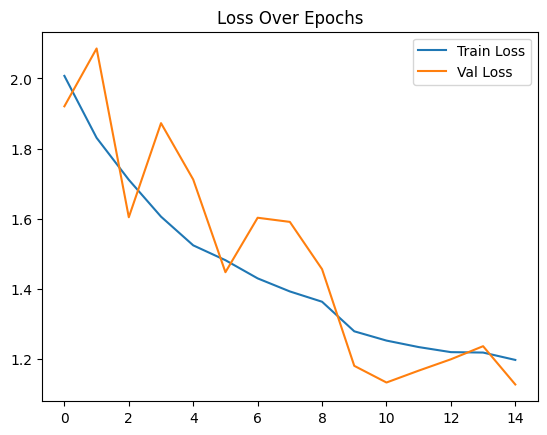

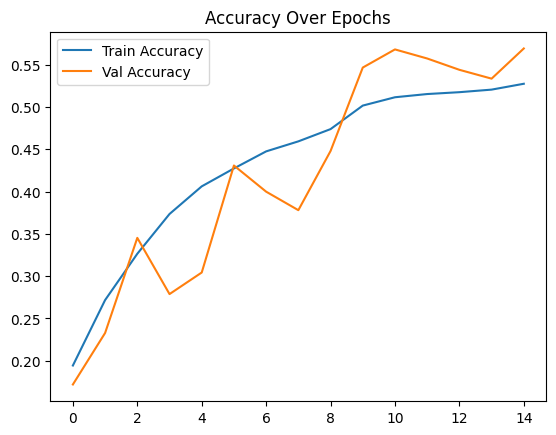

In [20]:
# Step 8: Plot Training Metrics
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

In [21]:
model.save("emotion_model.h5")
print("Model saved as emotion_model.h5")


Model saved as emotion_model.h5


In [22]:
# Step 10: Evaluate Model
loss, acc = model.evaluate(validation_generator, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.5145 - loss: 1.2195
Validation Loss: 1.1270
Validation Accuracy: 0.5691


113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step
              precision    recall  f1-score   support

       angry       0.48      0.49      0.48       958
     disgust       0.20      0.79      0.32       111
        fear       0.46      0.23      0.31      1024
       happy       0.85      0.76      0.80      1774
     neutral       0.49      0.63      0.55      1233
         sad       0.49      0.39      0.43      1247
    surprise       0.63      0.82      0.72       831

    accuracy                           0.57      7178
   macro avg       0.51      0.59      0.52      7178
weighted avg       0.58      0.57      0.56      7178



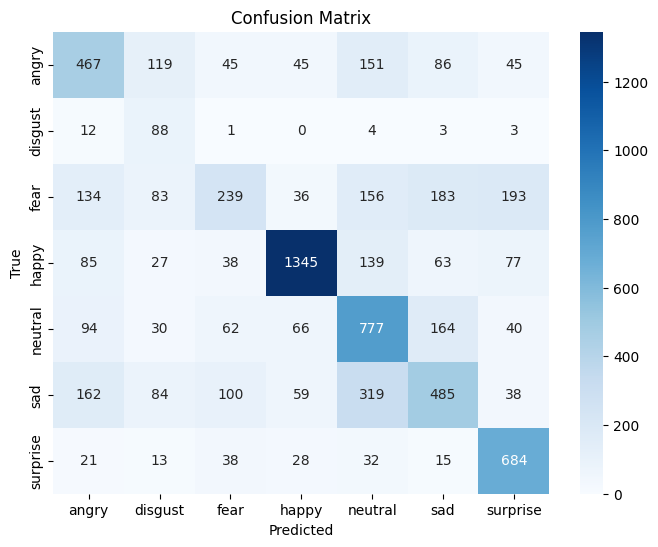

In [23]:
# Step 11: Confusion Matrix & Classification Report
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys(), cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
